# 3.2 GatedMLP eigenvector analysis

In [1]:
# Now you can import modules from this directory
import torch
import os
from src.plotter import EigenvectorPlotter
from src.heist import load_model
import imageio
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from src.helpers import action_space, evaluate_model
from collections import Counter
import random
from procgen import ProcgenEnv
from src.vec_env import VecExtractDictObs, VecMonitor, VecNormalize
from src.bilinear_impala import BimpalaCNN 
import matplotlib.pyplot as plt
from src.heist import create_venv as create_venv_simple
import einops
from src.utils import *
from src.helpers import ModelActivations, get_model_layer_names
import multiprocessing
from multiprocessing import Pool, set_start_method
from tqdm import tqdm
from functools import partial
import pickle

In [2]:
model_path = "/mnt/ssd-1/mechinterp/eris/bilinear_models/bimpala_simpleified_maze.pt"
model =load_model(model_path,7)
print(model)
for k in model.state_dict():
    print(k)
state_dict = model.state_dict()

Model loaded from /mnt/ssd-1/mechinterp/eris/bilinear_models/bimpala_simpleified_maze.pt
BimpalaCNN(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv_seqs): ModuleList(
    (0-2): 3 x ConvSequence(
      (max_pool2d): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
    )
  )
  (hidden_fc1): Linear(in_features=2048, out_features=256, bias=False)
  (hidden_fc2): Linear(in_features=2048, out_features=256, bias=False)
  (logits_fc): Linear(in_features=256, out_features=15,

/mnt/ssd-1/mechinterp/eris/RL_bilinear_experiments/bilinear_experiments/src/heist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [7]:
#we start with the latest residual block and decompose the input channel interactions
#ignoring the biases for now

W = state_dict["conv_seqs.2.res_block1.conv0.weight"]
V = state_dict["conv_seqs.2.res_block1.conv1.weight"]
U = state_dict["conv_seqs.2.res_block1.conv2.weight"]

#print(W.shape, V.shape)
out_channels, in_channels, kernel_width, kernel_height = W.shape

W_flatten = torch.randn(out_channels,in_channels,kernel_width*kernel_height)
V_flatten = torch.randn(out_channels,in_channels,kernel_width*kernel_height)

for i in range(out_channels):
    #the filter corresponding to the ith output channel
    #shape is in_channel, kernel_width, kernel_height
    for in1 in range(in_channels):
        W_flatten[i,in1,:] = torch.flatten(W[i,in1,:])
        V_flatten[i,in1,:] = torch.flatten(V[i,in1,:])


#let's compute the channel interactions
channel_interactions = torch.zeros(out_channels,in_channels,in_channels,kernel_width* kernel_height,kernel_width*kernel_height)

for i in range(out_channels):
    for in1 in range(in_channels):
        for in2 in range(in_channels):
            channel_interactions[i,in1,in2,:,:]= torch.outer(W_flatten[i,in1,:].t(),V_flatten[i,in2,:])


B = torch.einsum('oik,ojl->oijkl', W_flatten, V_flatten)
print(B.shape)

torch.Size([32, 32, 32, 49, 49])


In [9]:
class PPO:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def batch_act(self, observations):
        with torch.no_grad():
            # Ensure the observations are on the correct device and in the correct dtype
            observations = torch.tensor(observations, dtype=torch.float32, device=self.device)
            dist, value = self.model(observations)
            return dist.sample().cpu().numpy()
# Configuration
class Config:
    env_name = 'heist'
    num_envs = 1
    num_levels = 0  # Set to 0 for infinite levels or specify for deterministic levels
    start_level = 0
    distribution_mode = 'easy'
    gpu = 0
    model_file = model_path

# Create environment
def create_venv(config):
    venv = ProcgenEnv(num_envs=config.num_envs, env_name=config.env_name,
                      num_levels=config.num_levels, start_level=config.start_level,
                      distribution_mode=config.distribution_mode)
    venv = VecExtractDictObs(venv, "rgb")
    venv = VecMonitor(venv=venv, filename=None, keep_buf=100)
    return VecNormalize(venv=venv, ob=False)

# Run a single episode and collect frames
def rollout_episode(agent, env):
    obs = env.reset()
    frames = []
    done = False
    while not done:
        action = agent.batch_act(obs)
        obs, _, dones, infos = env.step(action)

        # Render the current environment state as an RGB array
        frame = env.render(mode='rgb_array')
        frames.append(frame)  # Append the RGB frame directly obtained from the environment

        done = dones.any()
    return frames
def rollout_episode_obs(agent, env):
    obs = env.reset()
    observations = [obs]
    done = False
    while not done:
        action = agent.batch_act(obs)
        obs, _, dones, infos = env.step(action)
        # Attempt to clone or serialize the environment state
        observations.append(obs)
        done = dones.any()

    return observations
def rollout_one_episode(agent, env, max_steps = 200):
    obs = env.reset()
    done = False

 
    while not done:
        # Decide randomly the number of steps to take (at least 1)
        
        for _ in range(max_steps):
            action = agent.batch_act(obs)
            obs, _, dones, infos = env.step(action)
            print(action, infos)
            # Check if the game has ended after each step
            done = dones.any()
            if done:
                break


    return env

# Create a GIF from frames
def create_gif(frames, filename='episode.gif'):
    with imageio.get_writer(filename, mode='I', duration=0.033) as writer:
        for frame in frames:
            writer.append_data(frame)
    print(f'GIF saved as {filename}')

# Setup
config = Config()
device = torch.device(f'cuda:{config.gpu}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create and configure the environment
env = create_venv(config)

# Load model
model = BimpalaCNN(obs_space=env.observation_space, num_outputs=env.action_space.n,kernel_size=7).to(device)
model.load_state_dict(torch.load(config.model_file, map_location=device))

# Setup the PPO agent with the model
agent = PPO(model, device)

# Run the episode and create a GIF
frames = rollout_episode(agent, env)
create_gif(frames)


Using device: cuda:0


/tmp/ipykernel_46407/2130544083.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.model_file, map_location=device))


GIF saved as episode.gif


In [10]:
def simulate_episodes(agent, env, num_episodes, save_gifs=False):
    action_counts = np.zeros(env.action_space.n, dtype=int)  # Assuming discrete action space

    for episode in range(num_episodes):
        obs = env.reset()
        frames = []
        actions = []
        done = False
        
        while not done:
            action = agent.batch_act(obs)
            obs, _, dones, infos = env.step(action)

            # Collect actions and frames
            actions.append(action[0])  # Assuming action is returned as a numpy array
            frame = env.render(mode='rgb_array')
            frames.append(frame)

            done = dones.any()

        # Update action counts
        unique, counts = np.unique(actions, return_counts=True)
        action_counts[unique] += counts

        # Optionally save the episode as a GIF
        if save_gifs:
            gif_filename = f'episode_{episode + 1}.gif'
            create_gif(frames, gif_filename)
    
    return action_counts
def plot_action_frequencies(action_counts):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(action_counts)), action_counts, color='blue')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.title('Action Frequencies Across Episodes')
    plt.show()

/tmp/ipykernel_46407/2327144894.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.model_file, map_location=device))


Testing action 0


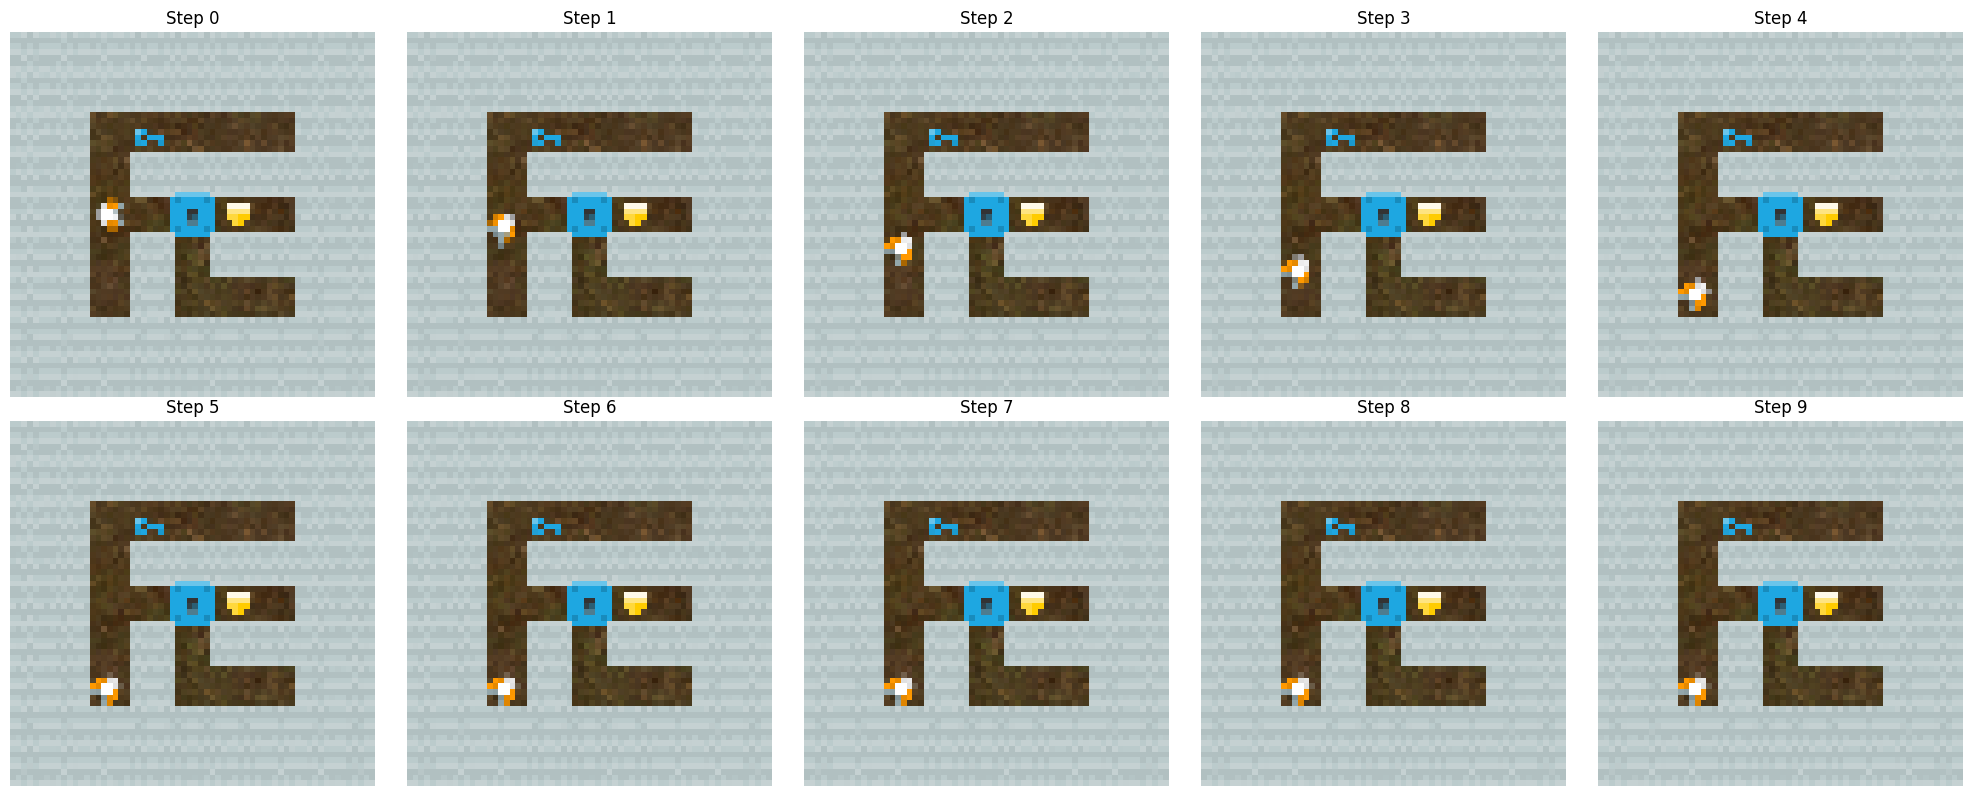

Testing action 1


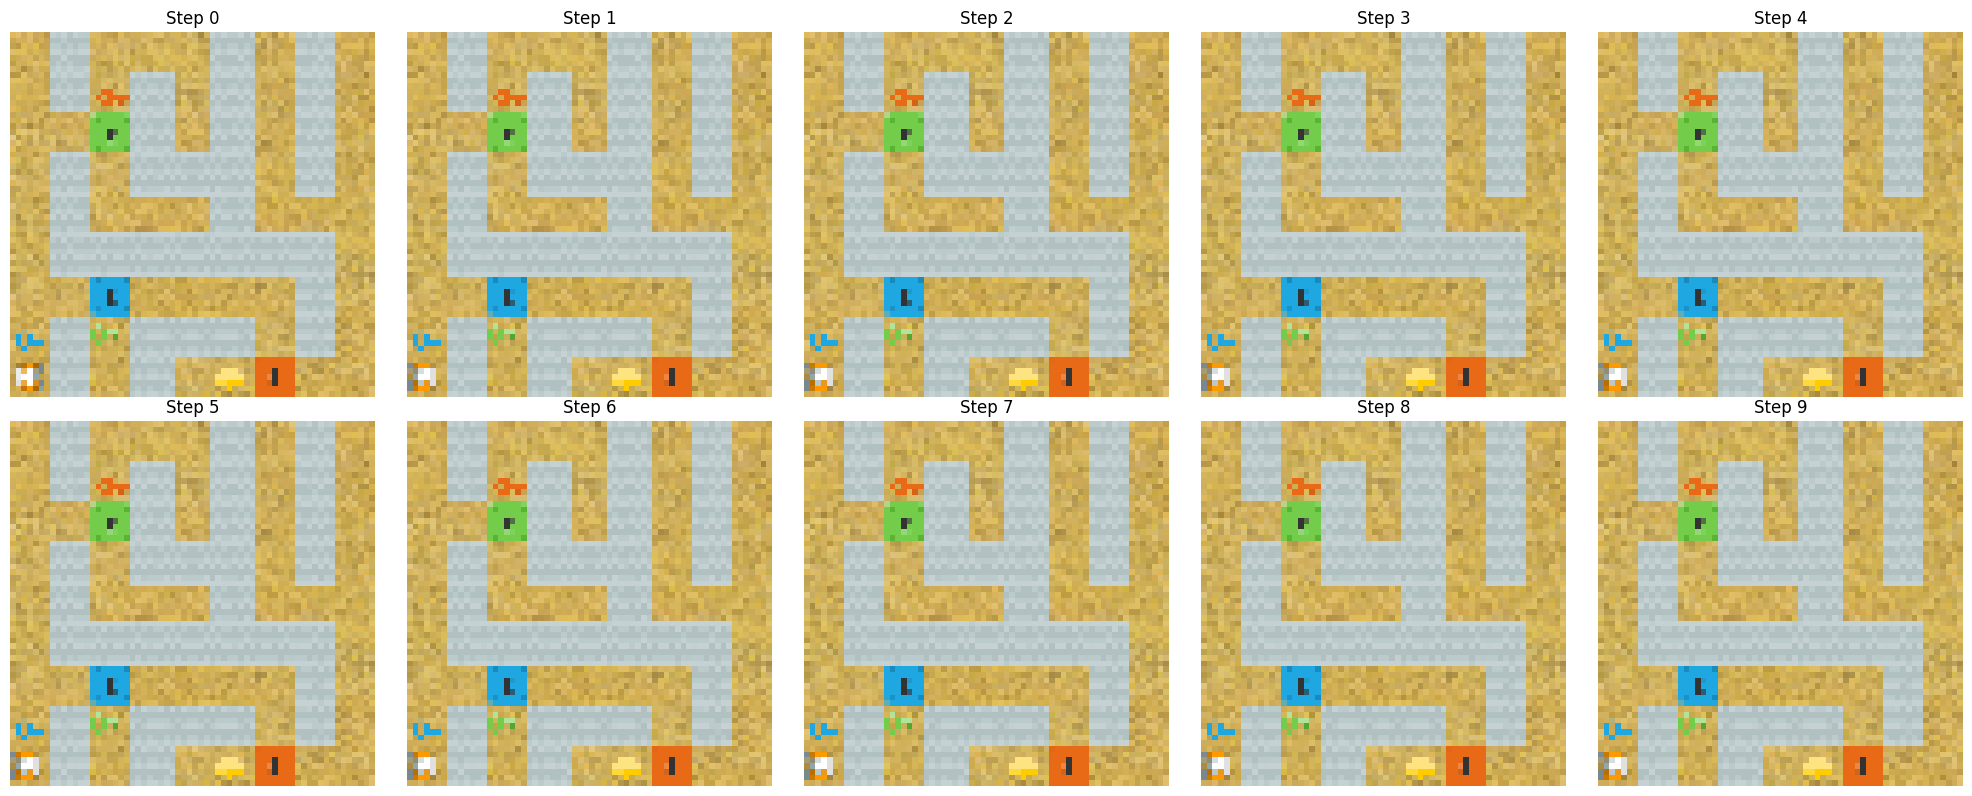

Testing action 2


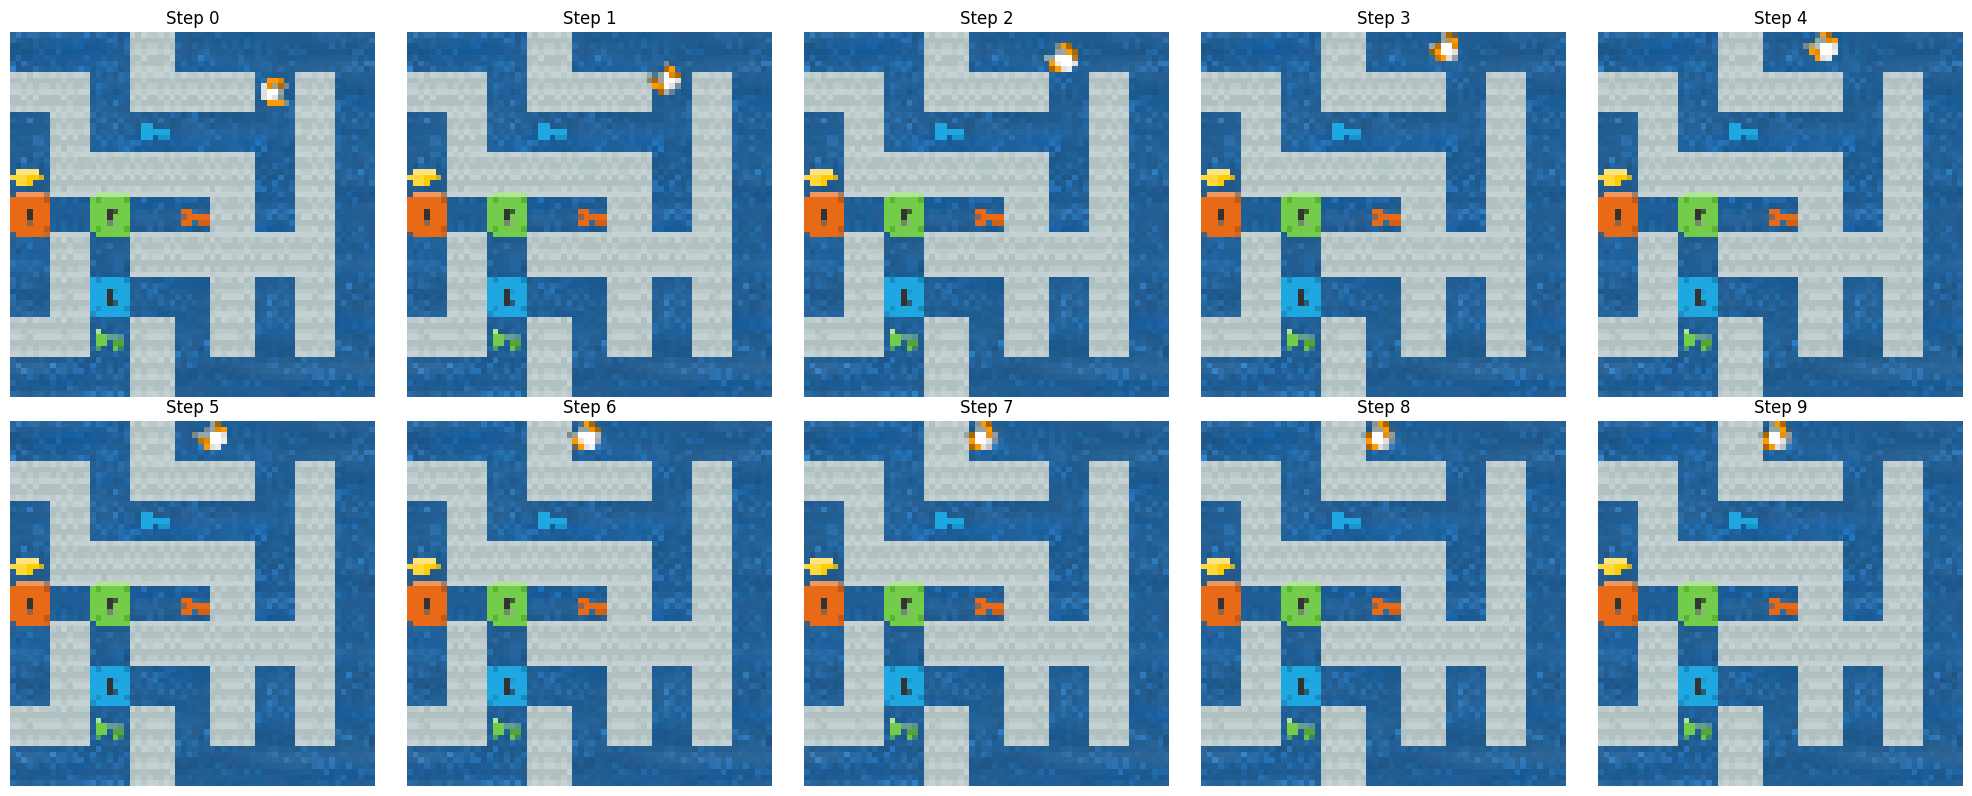

Testing action 3


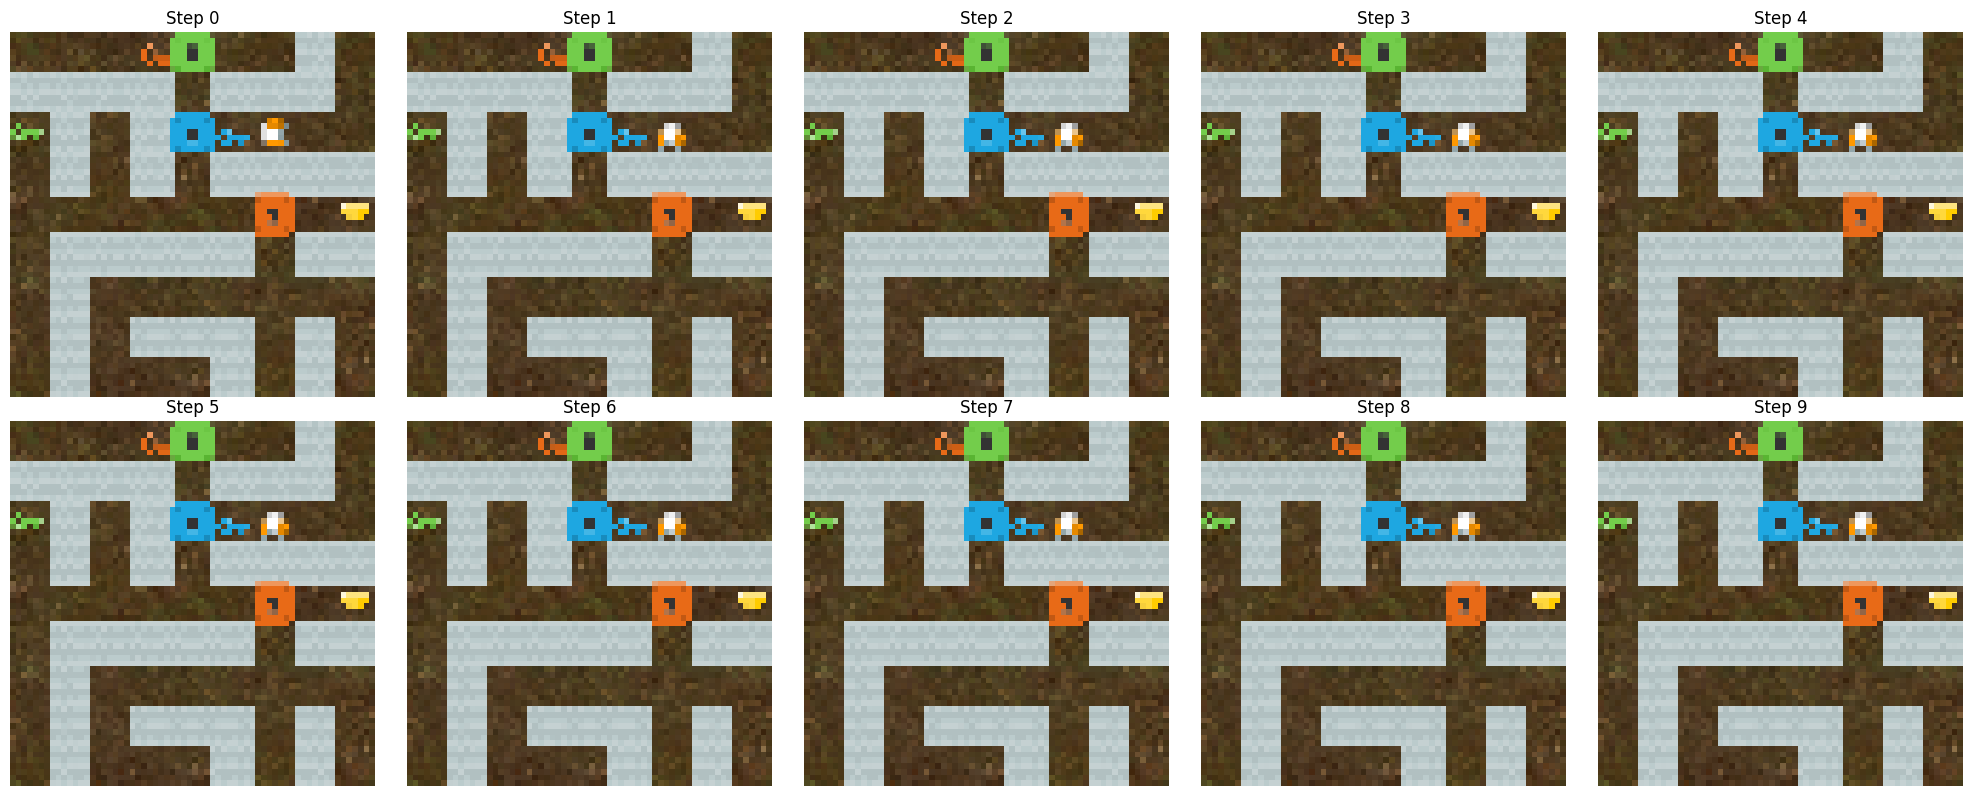

Testing action 4


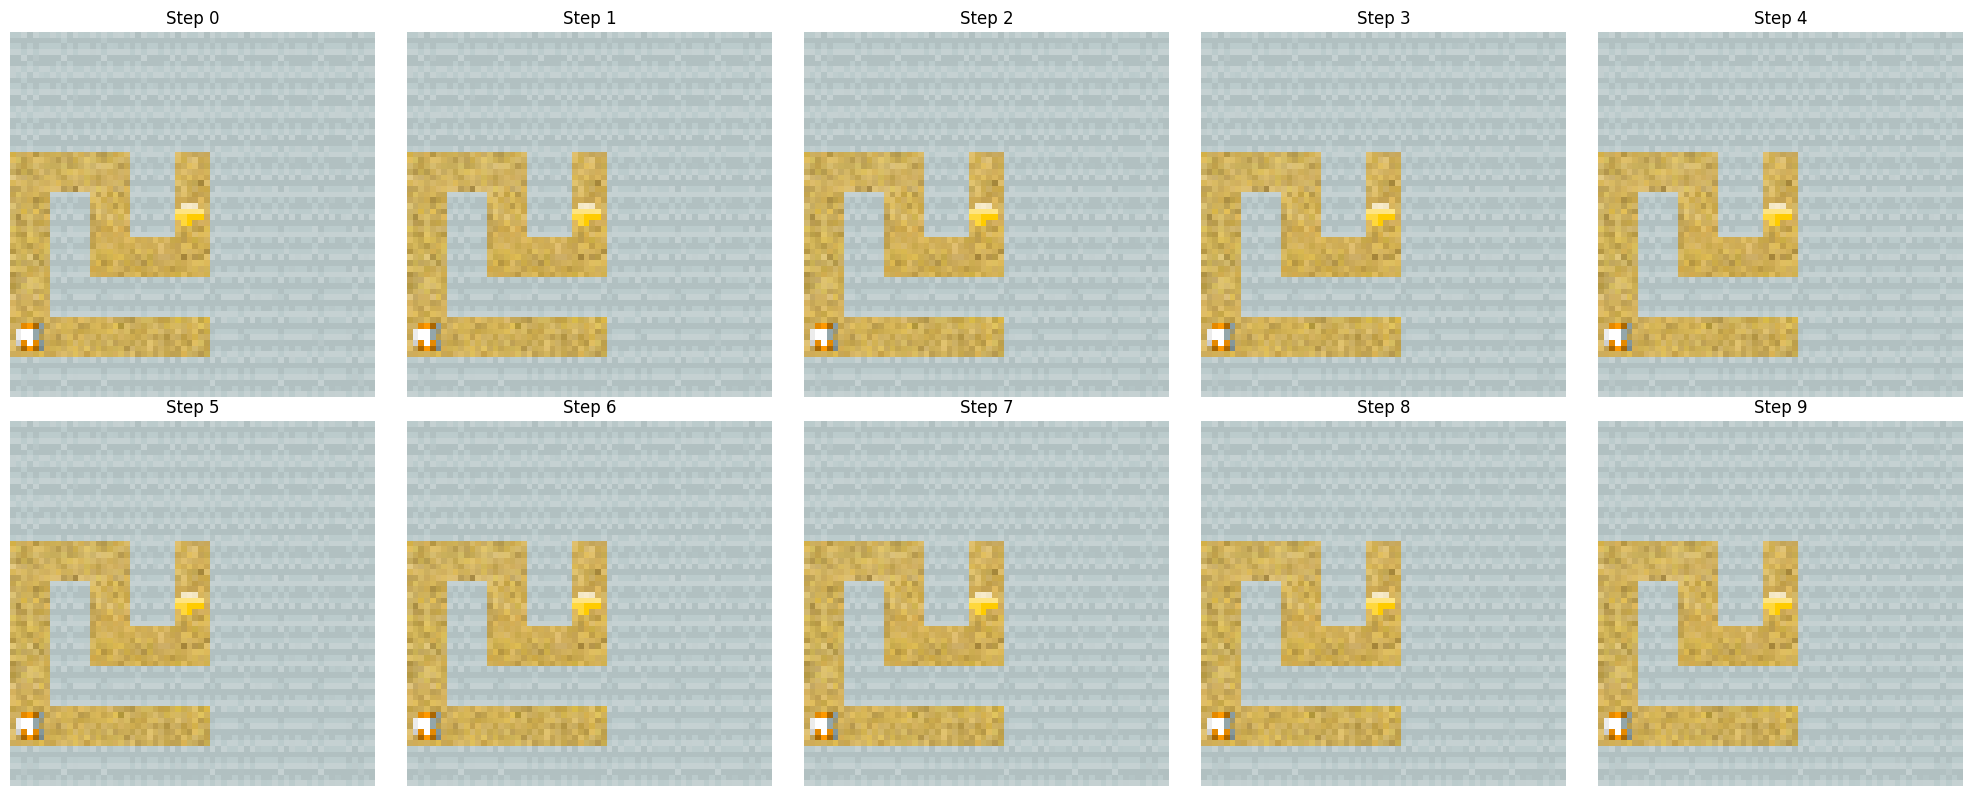

Testing action 5


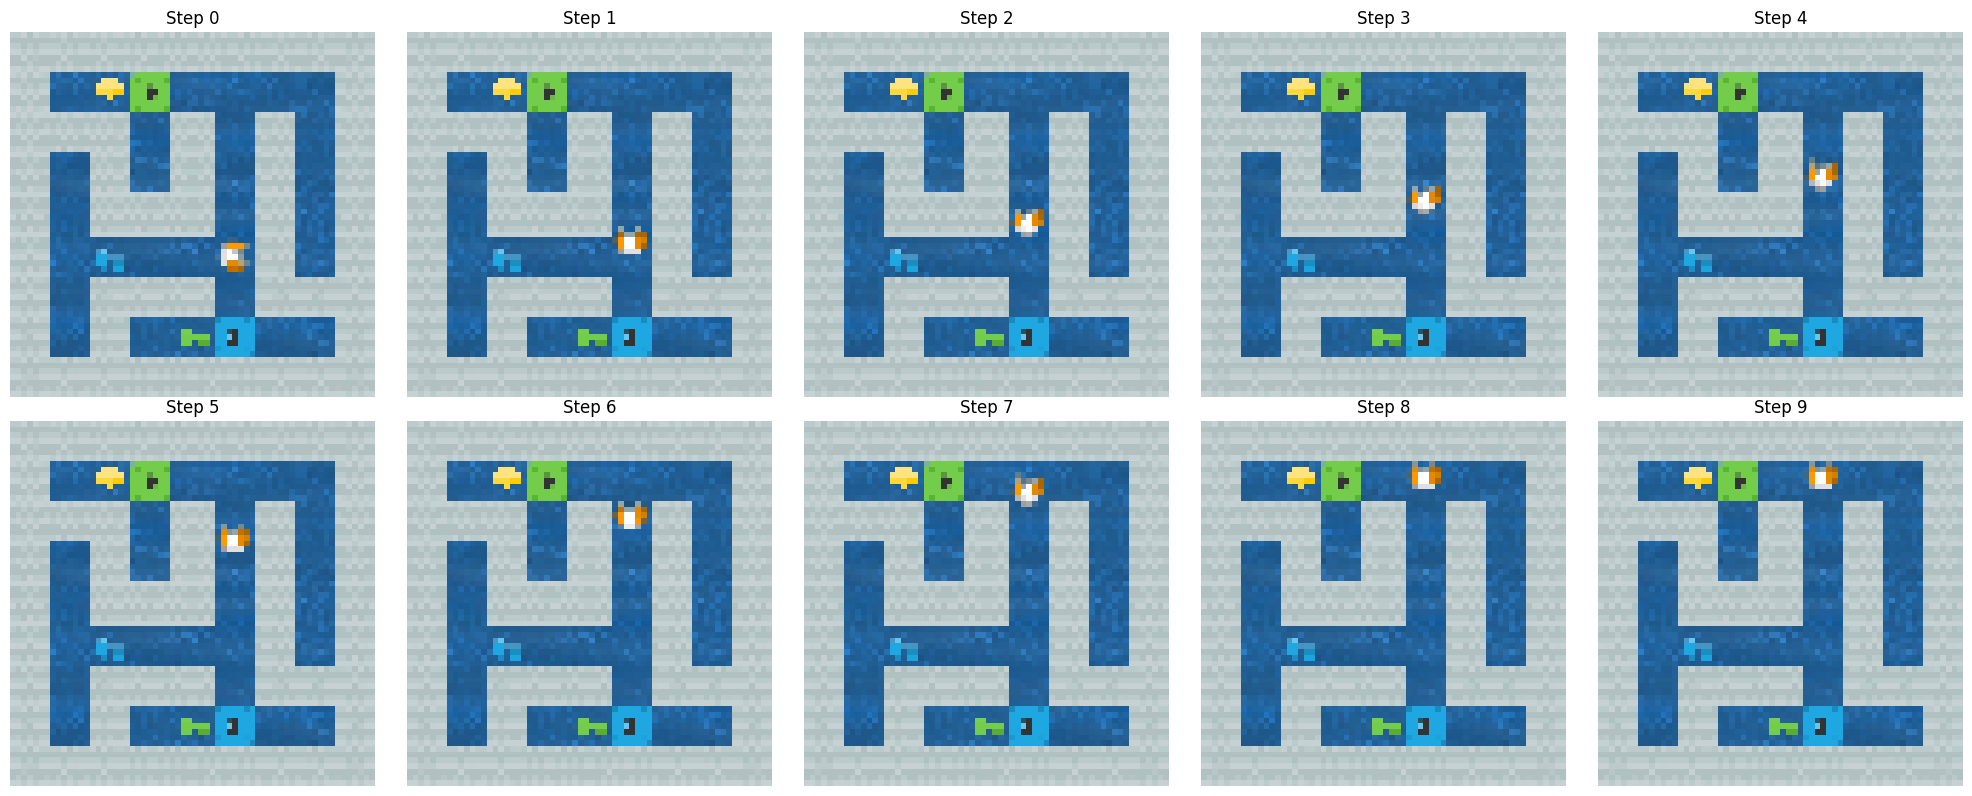

Testing action 6


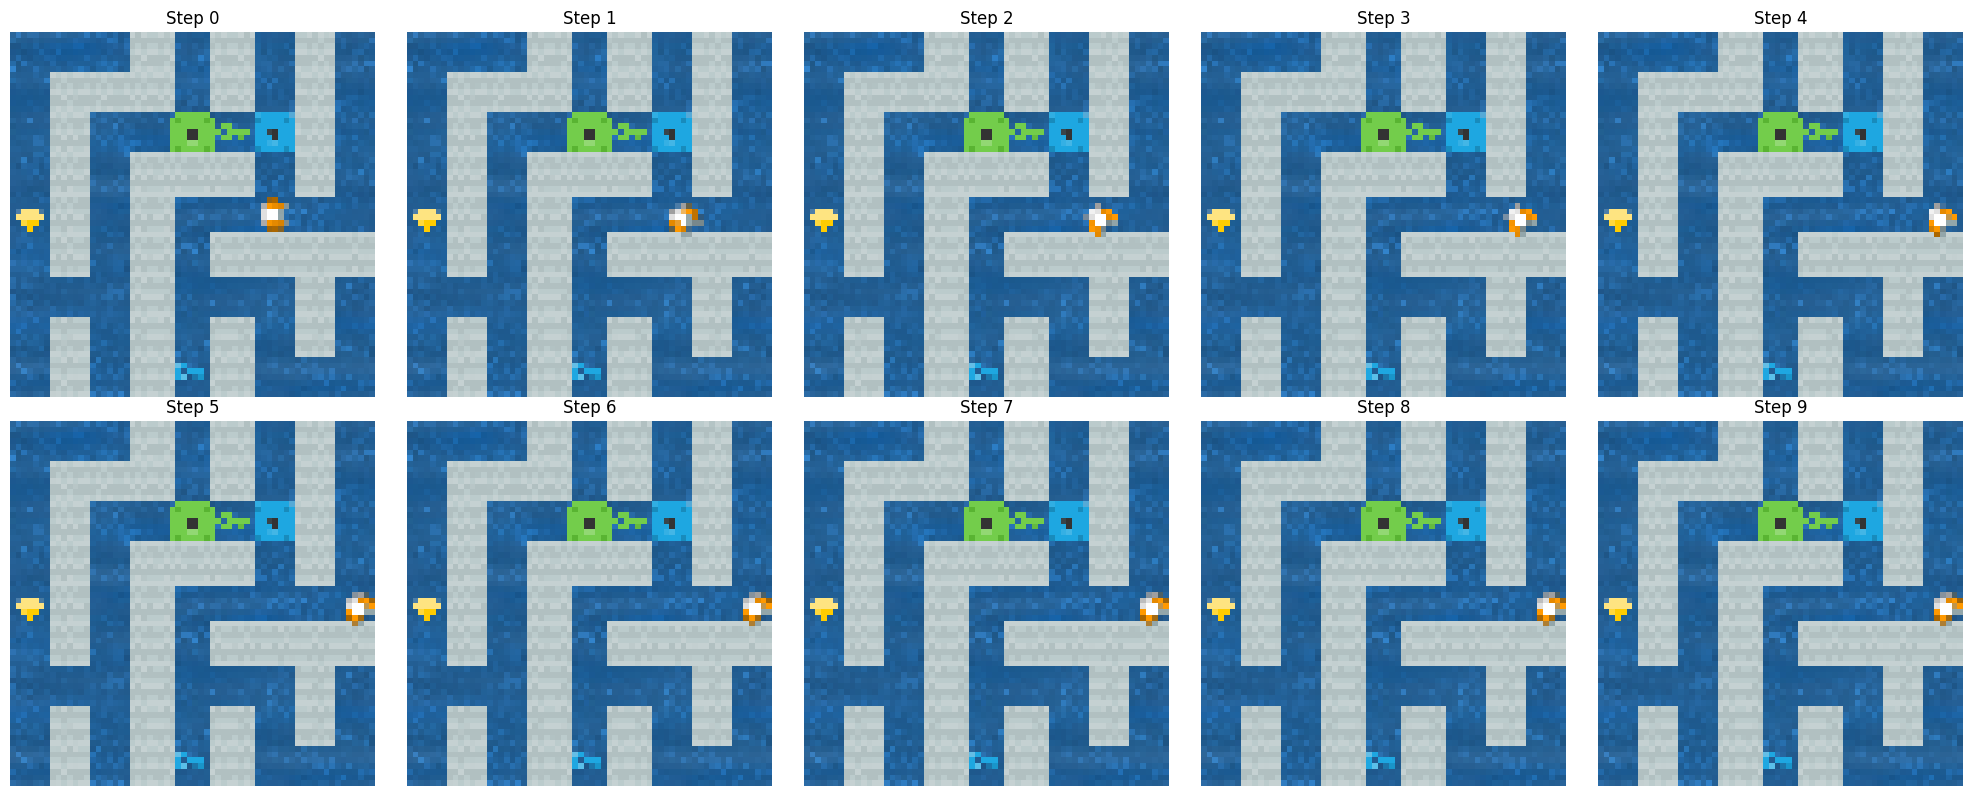

Testing action 7


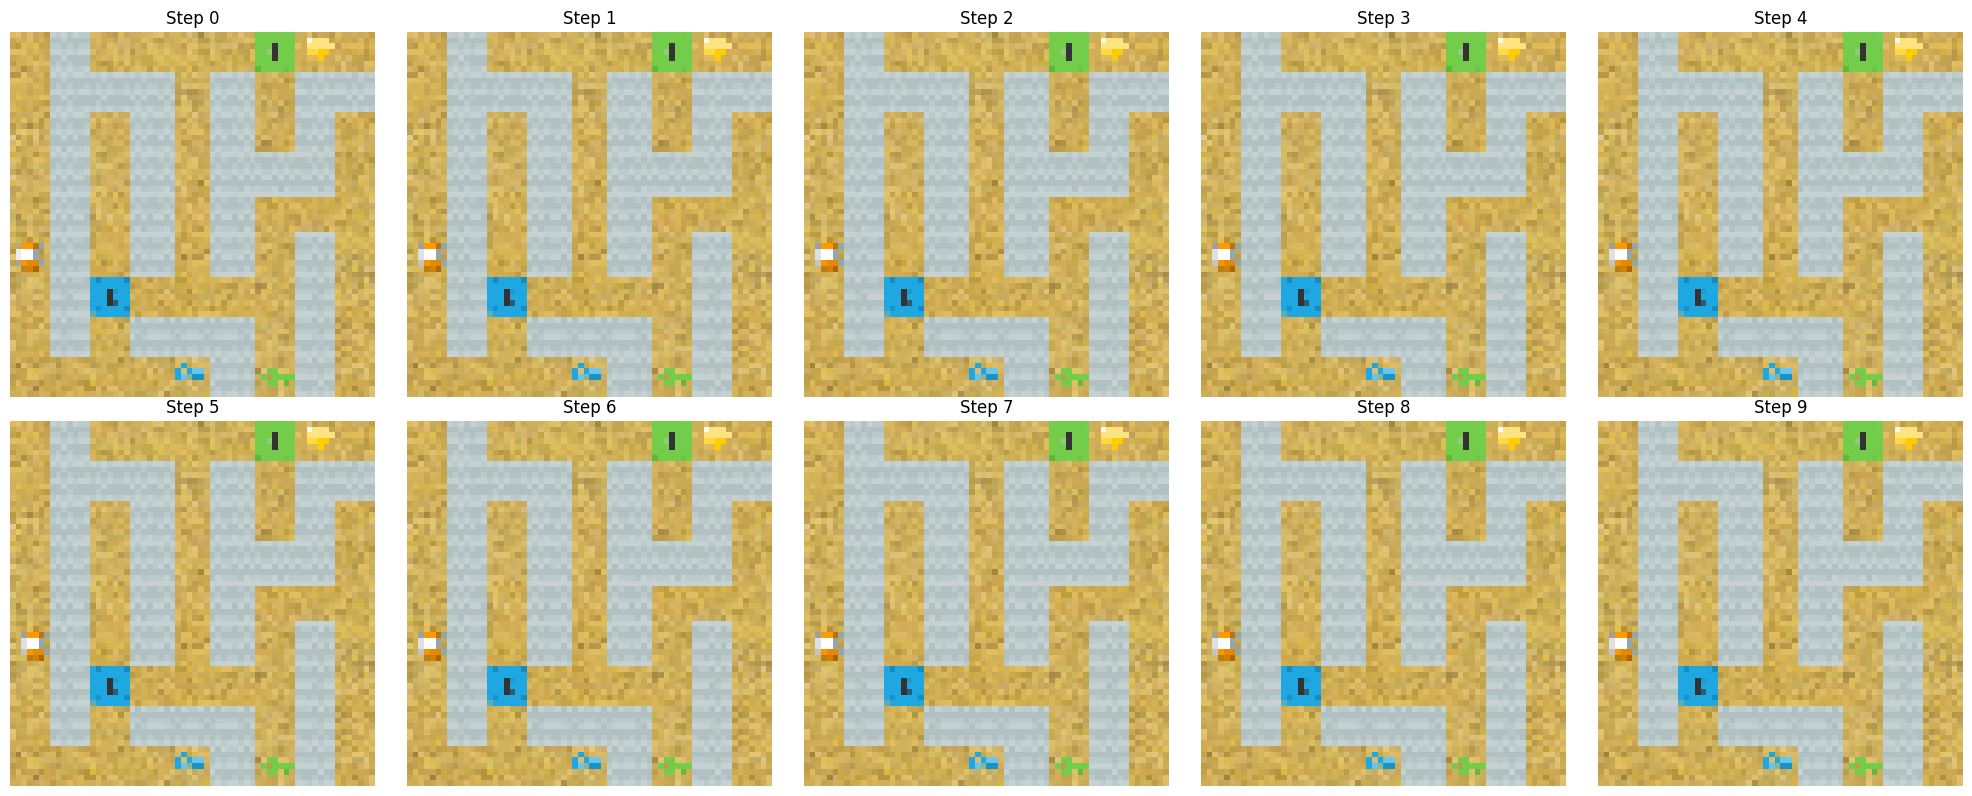

Testing action 8


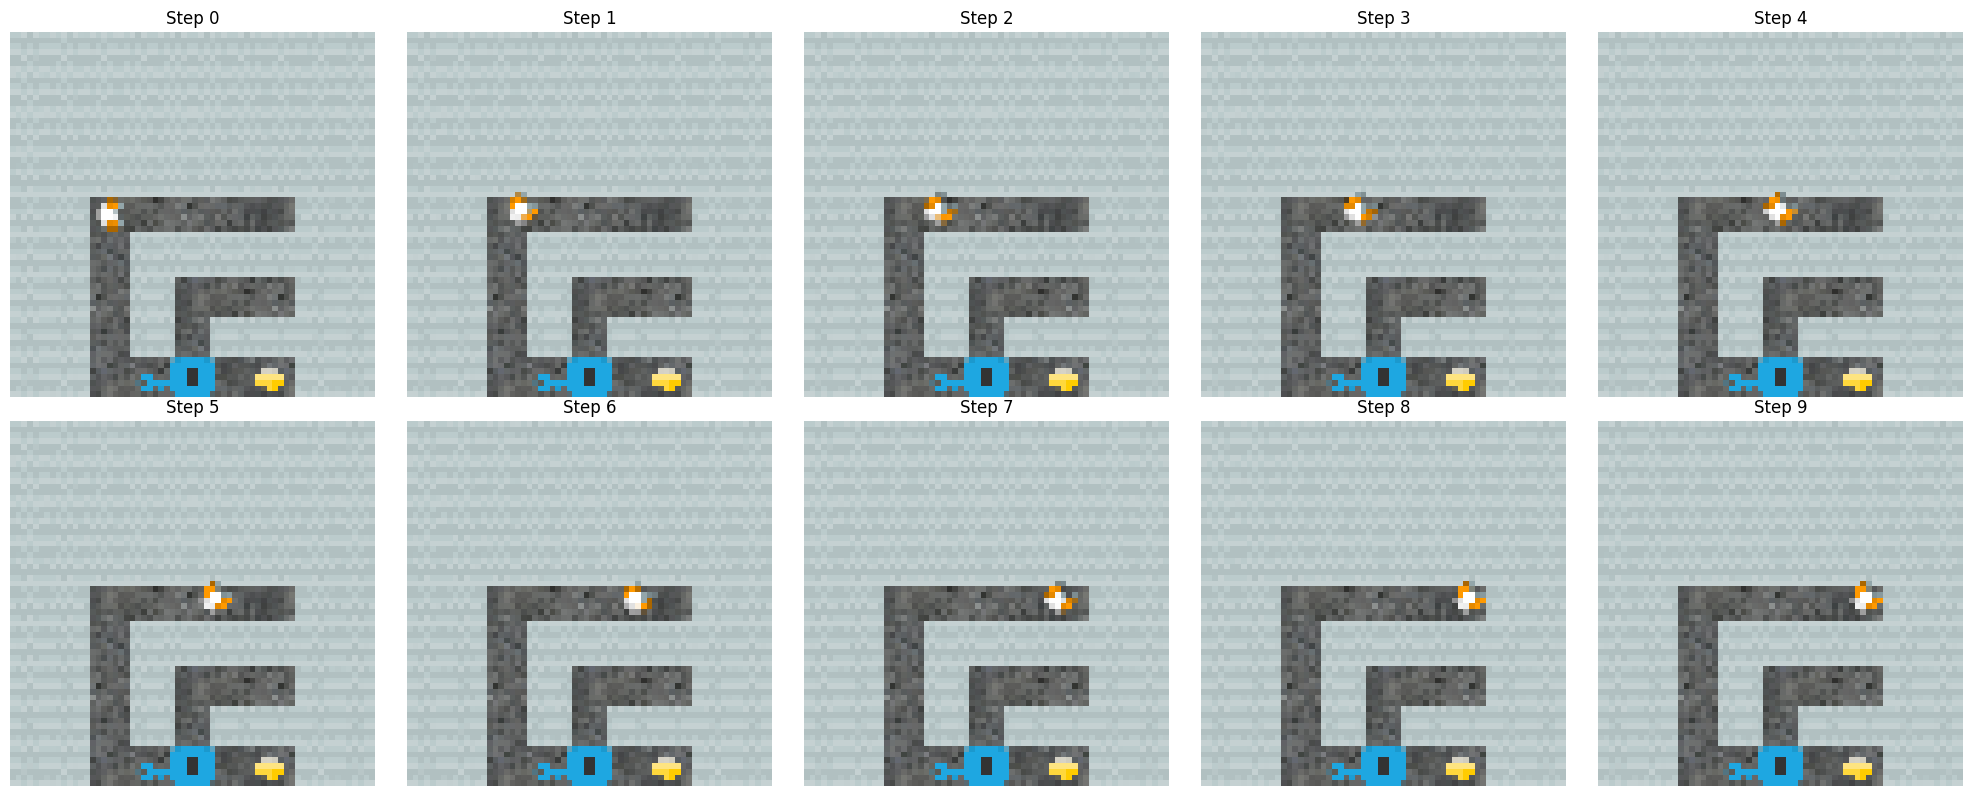

Testing action 9


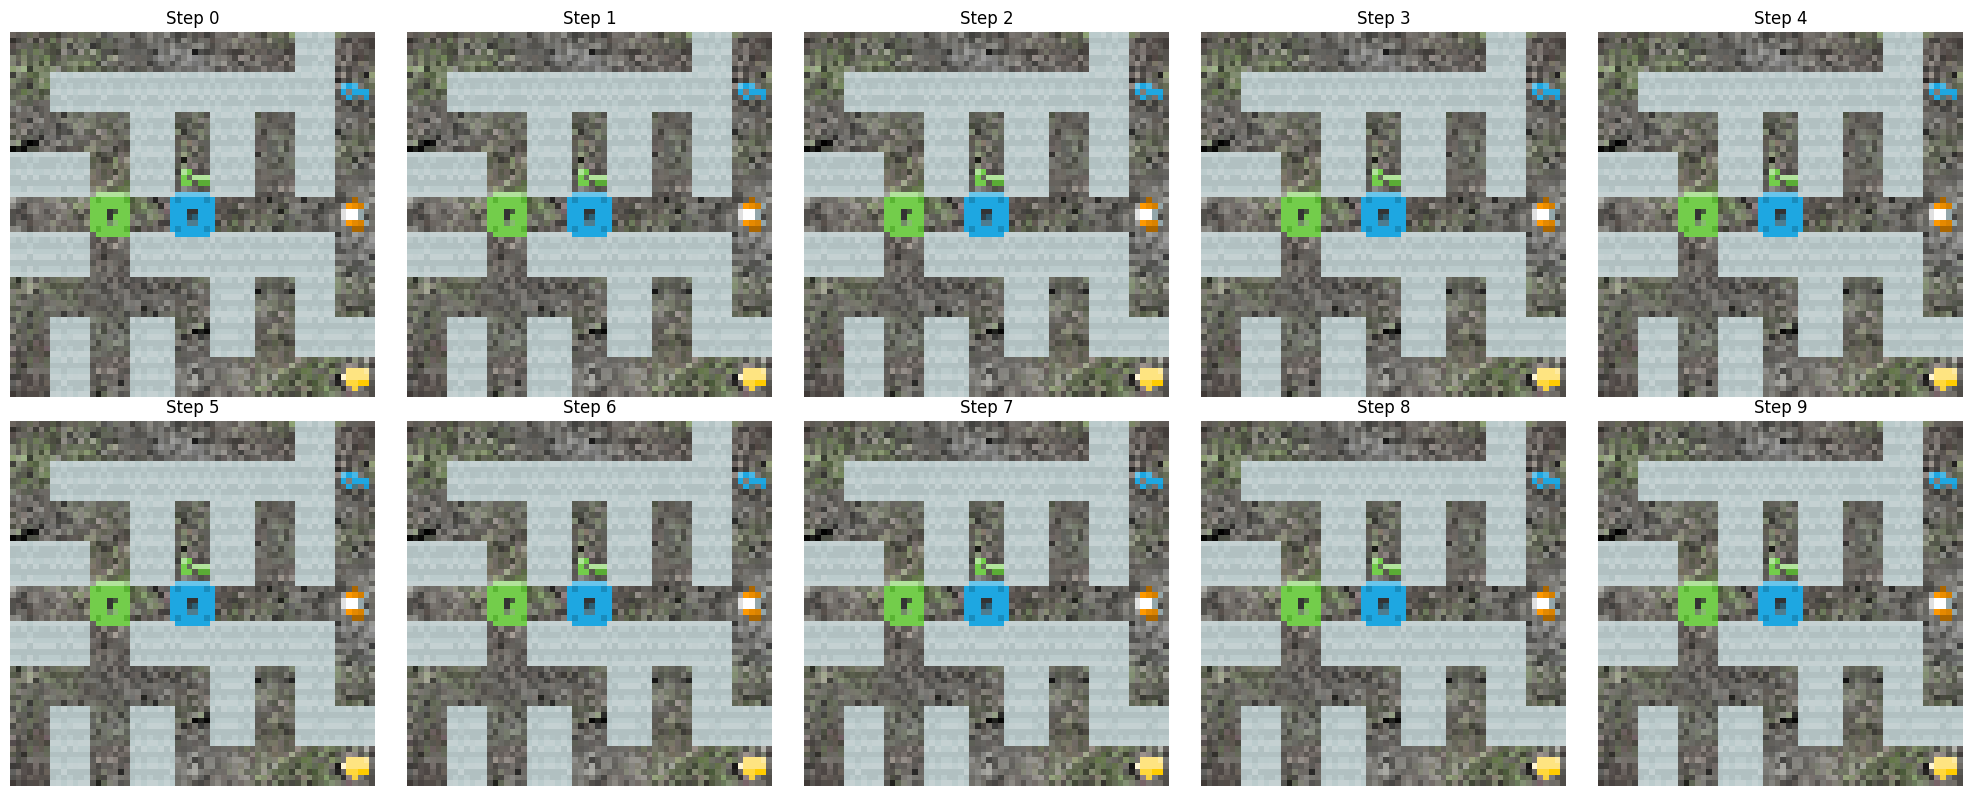

Testing action 10


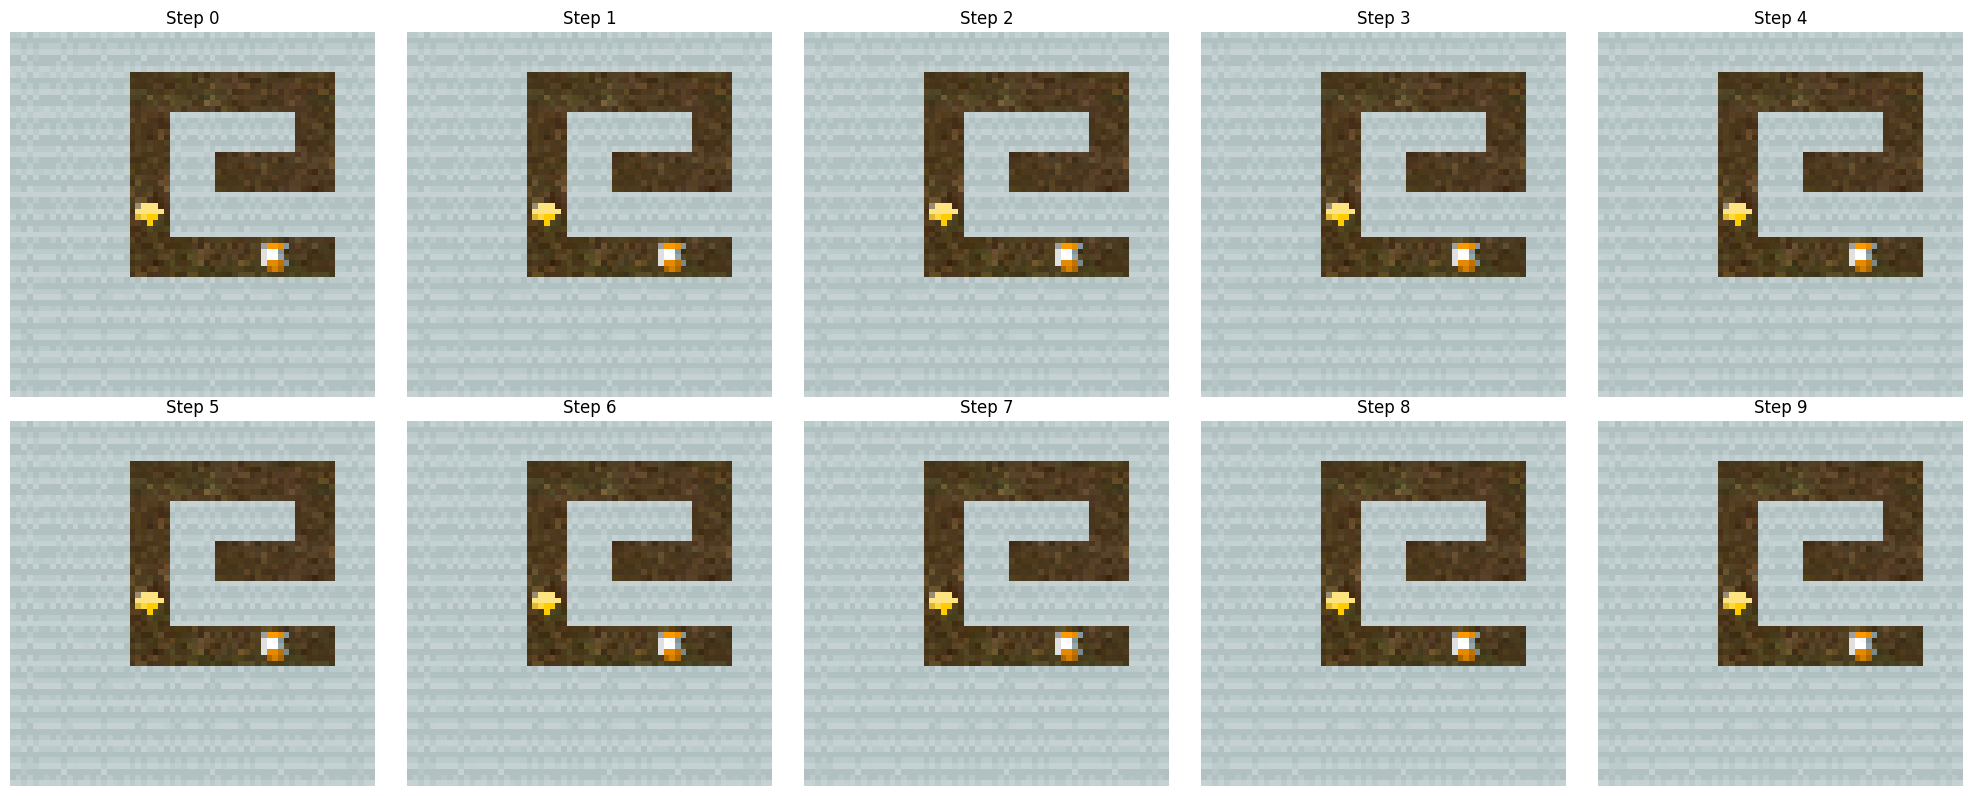

Testing action 11


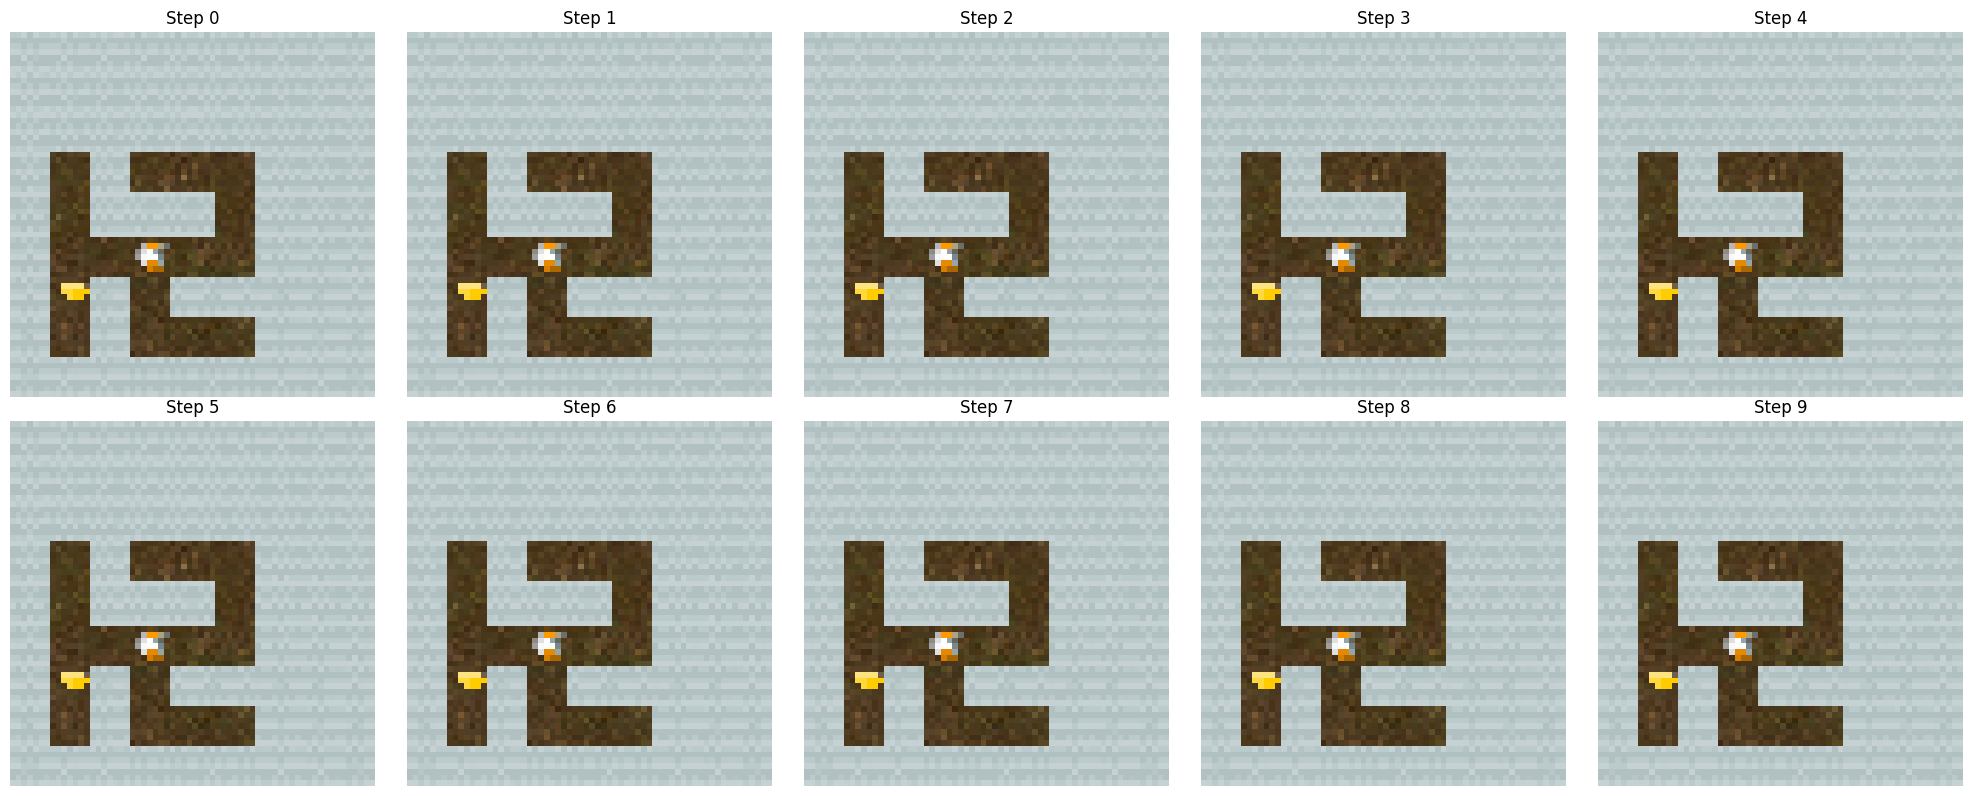

Testing action 12


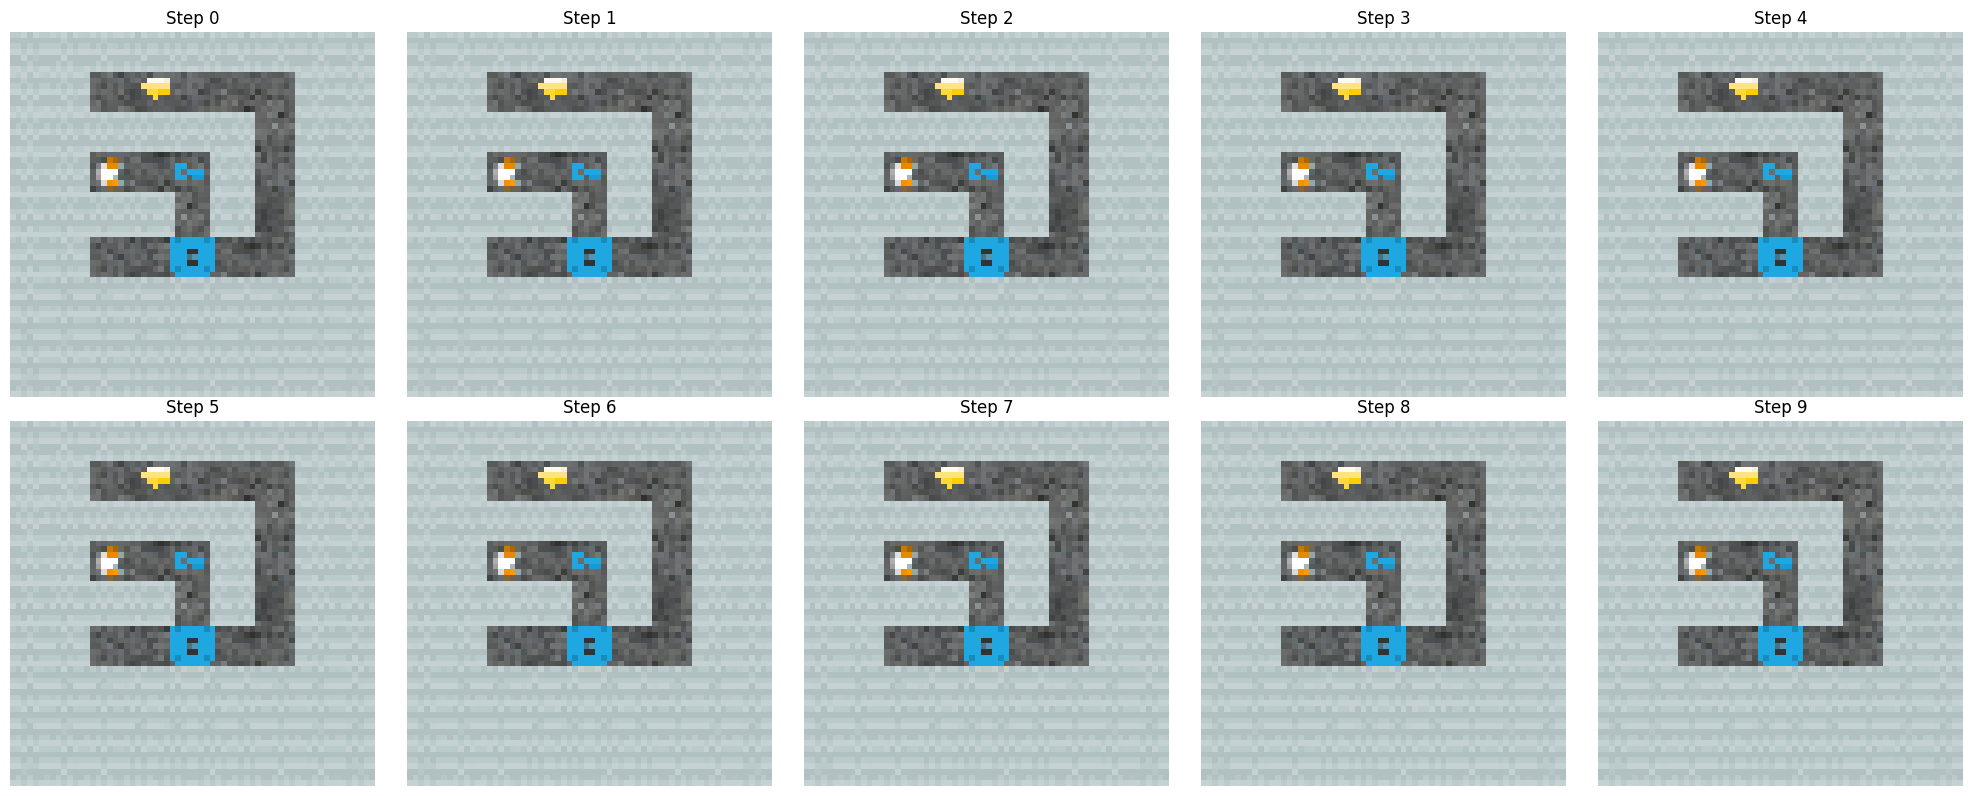

Testing action 13


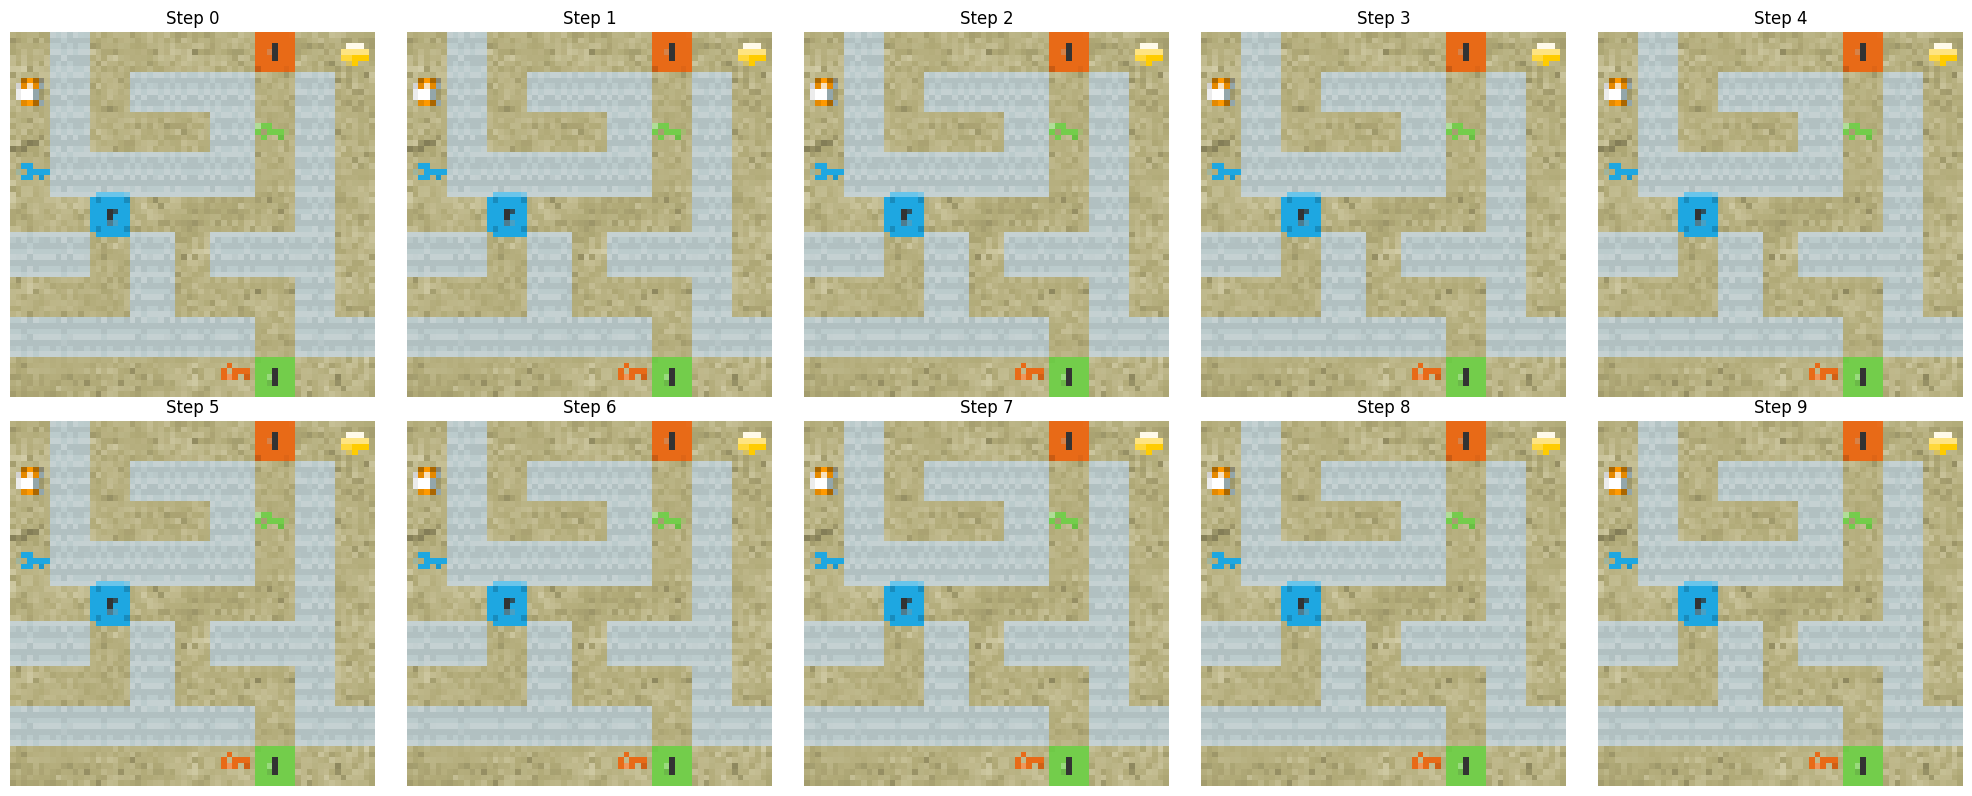

Testing action 14


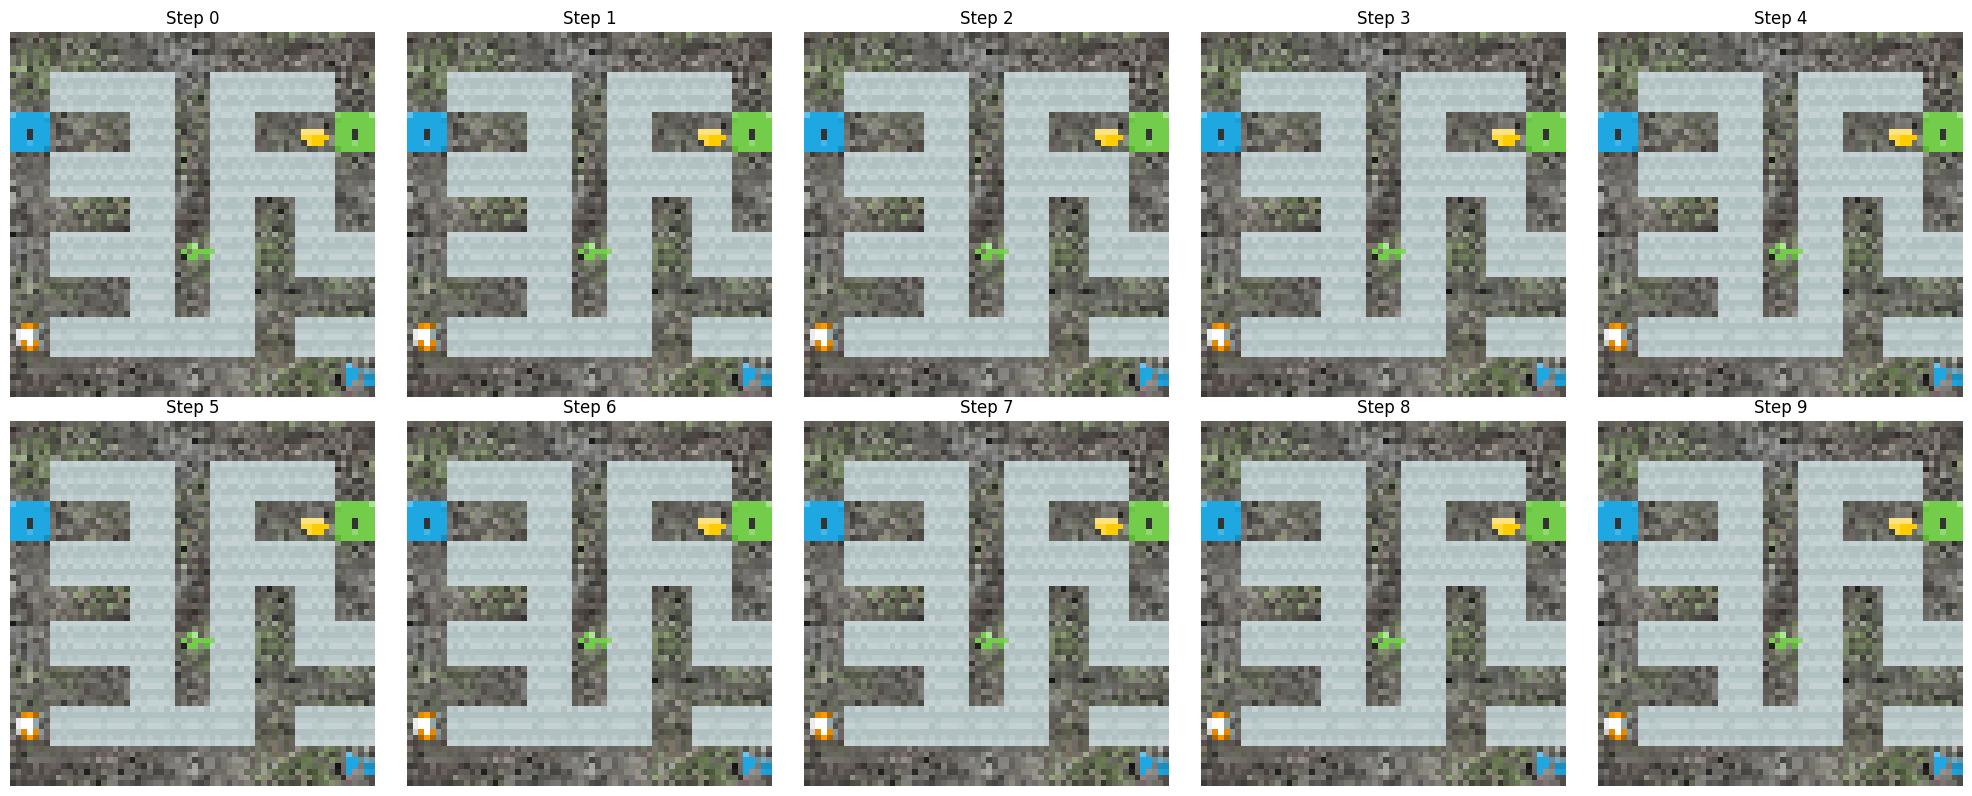

In [11]:
# Load model and setup PPO agent
model = BimpalaCNN(obs_space=env.observation_space, num_outputs=env.action_space.n, kernel_size=7).to(device)
model.load_state_dict(torch.load(config.model_file, map_location=device))
agent = PPO(model, device)


def visualize_action_effect(frames):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(frames):
            frame = frames[i]
            if isinstance(frame, np.ndarray):
                if frame.ndim == 4:
                    frame = frame.squeeze(0)
                if frame.shape[0] == 3:
                    frame = np.transpose(frame, (1, 2, 0))
                if frame.dtype in ['float32', 'float64'] and frame.max() > 1.0:
                    frame = frame / 255.0
            elif isinstance(frame, torch.Tensor):
                frame = frame.cpu().numpy()
                if frame.ndim == 4:
                    frame = frame.squeeze(0)
                if frame.shape[0] == 3:
                    frame = np.transpose(frame, (1, 2, 0))
                if frame.dtype in ['float32', 'float64'] and frame.max() > 1.0:
                    frame = frame / 255.0
            ax.imshow(frame)
            ax.set_title(f"Step {i}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

def take_action_repeatedly(env, action, steps=10):
    obs = env.reset()
    frames = [obs]
    for _ in range(steps):
        obs, reward, done, info = env.step(np.array([action]))
        frames.append(obs)
        if np.all(done):
            break
    return frames

def investigate_actions():
    for action in range(env.action_space.n):
        venv = create_venv_simple(num_envs=1, start_level=random.randint(0, 1000000000), num_levels=0)
        print(f"Testing action {action}")
        frames = take_action_repeatedly(venv, action)
        visualize_action_effect(frames)
      

investigate_actions()

GIF saved as episode_1.gif


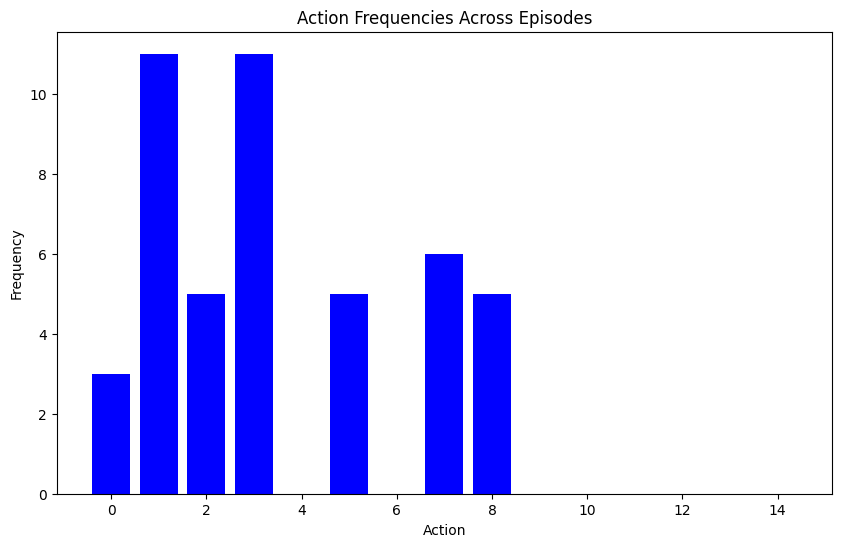

In [12]:
# Simulate multiple episodes and visualize action frequencies
num_episodes = 1 # Define how many episodes you want to simulate
action_counts = simulate_episodes(agent, env, num_episodes, save_gifs=True)
plot_action_frequencies(action_counts)

Therefore the possible actions of the agent are :

    0.  Move Left and Down (diagonal)

    1.  Move Left

    2.  Move Left and Up (diagonal)

    3.  Move Down

    5.  Move Up

    6.  Move Right and Down (diagonal)

    7.  Move Right

    8.  Move Right and Up (diagonal)

(We can see that it is mostly straight movements over diagonal movements)


# Decomposing hiddenfc expanded across each action of the player


In [13]:
print(list(state_dict.keys()))
W = state_dict["hidden_fc1.weight"].to("cpu").detach()
V = state_dict["hidden_fc2.weight"].to("cpu").detach()
W_out = state_dict["logits_fc.weight"].to("cpu").detach()
print(W.shape)
B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = 2048)

B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")
print(B_proj.shape)
B_proj1 = 0.5 * B_proj + 0.5 * B_proj.transpose(-2,-1)

['bfc1', 'bfc2', 'conv_seqs.0.conv.weight', 'conv_seqs.0.conv.bias', 'conv_seqs.0.res_block0.b_0', 'conv_seqs.0.res_block0.b_1', 'conv_seqs.0.res_block0.conv0.weight', 'conv_seqs.0.res_block0.conv0.bias', 'conv_seqs.0.res_block0.conv1.weight', 'conv_seqs.0.res_block0.conv1.bias', 'conv_seqs.0.res_block0.conv2.weight', 'conv_seqs.0.res_block0.conv2.bias', 'conv_seqs.0.res_block1.b_0', 'conv_seqs.0.res_block1.b_1', 'conv_seqs.0.res_block1.conv0.weight', 'conv_seqs.0.res_block1.conv0.bias', 'conv_seqs.0.res_block1.conv1.weight', 'conv_seqs.0.res_block1.conv1.bias', 'conv_seqs.0.res_block1.conv2.weight', 'conv_seqs.0.res_block1.conv2.bias', 'conv_seqs.1.conv.weight', 'conv_seqs.1.conv.bias', 'conv_seqs.1.res_block0.b_0', 'conv_seqs.1.res_block0.b_1', 'conv_seqs.1.res_block0.conv0.weight', 'conv_seqs.1.res_block0.conv0.bias', 'conv_seqs.1.res_block0.conv1.weight', 'conv_seqs.1.res_block0.conv1.bias', 'conv_seqs.1.res_block0.conv2.weight', 'conv_seqs.1.res_block0.conv2.bias', 'conv_seqs.1.re

/home/dali/Documents/GitHub/RL_bilinear_experiments/.venv/lib/python3.10/site-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


torch.Size([15, 2048, 2048])


torch.Size([15, 2048, 2048])


18

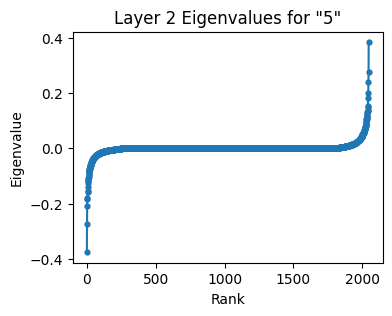

In [14]:
class_indices = [0,1,2,3,5,6,7,8]
#Moving up
class_idx = 5
Q = B_proj1[class_idx]
print(B_proj.shape)
eigvals1, eigvecs1 = torch.linalg.eigh(Q)

plt.figure(figsize=(4,3))
plt.plot(eigvals1,'.-', markersize=7)
plt.ylabel('Eigenvalue')
plt.xlabel('Rank')
plt.title(f'Layer 2 Eigenvalues for "{class_idx}"')
len([eigenval for eigenval in eigvals1 if eigenval >0.1])

In [15]:
def process_and_plot_topk_eigenvectors(eigvals, eigvecs, topk, plot=True):
    # Reshape eigenvectors from flat vector to image dimensions
    reshaped_eigvecs = eigvecs.view(-1, 32, 8, 8)

    # Extract positive and negative eigenvalues separately
    positive_indices = eigvals > 0
    negative_indices = eigvals < 0

    # Sort positive and negative eigenvalues separately
    pos_sorted_indices = torch.argsort(eigvals[positive_indices], descending=True)
    neg_sorted_indices = torch.argsort(eigvals[negative_indices])  # Sorting in ascending to find most negative

    # Adjust topk based on the number of available positive/negative eigenvalues
    top_pos_indices = pos_sorted_indices[:min(topk, len(pos_sorted_indices))]
    top_neg_indices = neg_sorted_indices[:min(topk, len(neg_sorted_indices))]

    # Re-index to original eigenvector indices
    top_pos_indices = torch.nonzero(positive_indices)[top_pos_indices].squeeze()
    top_neg_indices = torch.nonzero(negative_indices)[top_neg_indices].squeeze()

    # Function to plot eigenvectors
    def plot_eigenvectors(eigenvectors, eigenvalues, title_prefix):
        for i in range(len(eigenvectors)):
            fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))  # Create subplots for up to 32 channels
            title = f"{title_prefix} Eigenvector {i+1}, Eigenvalue: {eigenvalues[i]:.4f}"
            fig.suptitle(title)
            axes = axes.flatten()
            for j, ax in enumerate(axes):
                if j < eigenvectors[i].shape[0]:  # Check if the channel exists
                    ax.imshow(eigenvectors[i][j], cmap='gray')
                    ax.axis('off')
                else:
                    ax.axis('off')  # Turn off axis for unused subplots
            plt.show()
    if plot:
        # Plot top positive eigenvectors
        if len(top_pos_indices) > 0:
            plot_eigenvectors(reshaped_eigvecs[top_pos_indices], eigvals[top_pos_indices], "Top Positive")
        else:
            print("No positive eigenvalues found within the top k range.")

        # Plot top negative eigenvectors
        if len(top_neg_indices) > 0:
            plot_eigenvectors(reshaped_eigvecs[top_neg_indices], eigvals[top_neg_indices], "Top Negative")
        else:
            print("No negative eigenvalues found within the top k range.")

    return reshaped_eigvecs[top_pos_indices], eigvals[top_pos_indices], reshaped_eigvecs[top_neg_indices], eigvals[top_neg_indices]



In [16]:
def create_dataset_one_episode(model, device, num_levels= 0):
    
    env = create_venv_simple(num_envs=1, start_level=random.randint(0, 1000000000), num_levels=num_levels)
    agent = PPO(model, device)
    envs = rollout_episode_obs(agent, env)
    return envs

def get_activations(modelactivations: ModelActivations,observation, layers, device):
    observation = torch.tensor(observation, device=device, dtype=torch.float32)
    _, activations = modelactivations.run_with_cache(observation, layers)
    return activations

def get_activations_for_dataset(modelactivations, dataset, layers, device):
    dataset_with_activations = []
    # Use tqdm to show a progress bar over the dataset iteration
    for observation in tqdm(dataset, desc="Computing activations"):
        # Convert the observation to a tensor
        observation_tensor = torch.tensor(observation, device=device, dtype=torch.float32)
        # Compute activations
        _, activation = modelactivations.run_with_cache(observation_tensor, layers)
        # Append both observation and its activations to the new dataset list
        dataset_with_activations.append((observation_tensor, activation[layers[0].replace('.', '_')][0]))
    return dataset_with_activations

def find_top_observations_by_eigenvector(dataset, eigenvectors, eigenvalues, top_k=15):
    device = eigenvectors.device
    eigenvectors_flat = eigenvectors.reshape(eigenvectors.size(0), -1).to(device)
    eigenvalues = eigenvalues.to(device)
    
    # Ensure eigenvectors and eigenvalues have the same number of elements
    assert eigenvectors_flat.size(0) == eigenvalues.size(0), "Number of eigenvectors and eigenvalues must match"
    
    results = {i: {'top_observations': [], 'max_score': float('-inf')} for i in range(eigenvectors.size(0))}

    # Wrap the outer loop with tqdm for a progress bar
    for observation, activation in tqdm(dataset, desc="Processing Observations"):
        
        activation_flat = activation.reshape(1, -1).to(device)
        
        # Compute dot product for each eigenvector
        dot_products = torch.einsum('a, n a -> n', activation_flat.squeeze(0), eigenvectors_flat)
        dot_products = dot_products**2
        
        # Multiply each dot product by its corresponding eigenvalue
        scores = dot_products * torch.abs(eigenvalues)

        # Update results for each eigenvector
        for i, score in enumerate(scores):
            if score > results[i]['max_score']:
                results[i]['max_score'] = score.item()
            results[i]['top_observations'].append((observation, score.item()))

    # Sort and limit to top k observations for each eigenvector after all are processed
    for i in results:
        results[i]['top_observations'].sort(key=lambda x: x[1], reverse=True)
        results[i]['top_observations'] = results[i]['top_observations'][:top_k]

    return results


In [18]:
#dear lord this takes a good 10 mins
def generate_dataset():
    for j in range(5):
        dataset = []
        # Wrap the inner loop with tqdm for progress tracking
        for i in tqdm(range(200), desc=f'Generating Dataset for Batch {j}'):
            dataset.extend(create_dataset_one_episode(model, device))
        
        # Save the dataset to a pickle file
        with open(f'dataset{j}.pickle', 'wb') as file:
            pickle.dump(dataset, file)

In [21]:
def load_and_combine_datasets(num_files, dataset_folder=""):
    # List to hold all observations from all datasets
    all_observations = []
    
    # Generate file names based on known naming pattern
    dataset_files = [f'datasets/dataset{i}.pickle' for i in range(num_files)]

    # Loop through each file, load it, and extend the master list
    for dataset_file in dataset_files:
        file_path = os.path.join(dataset_folder, dataset_file)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            all_observations.extend(data)
    
    return all_observations
dataset = load_and_combine_datasets(5)
print(len(dataset))

54565


In [15]:
modelactivations = ModelActivations(model)
print(get_model_layer_names(model))
enhanced_dataset = get_activations_for_dataset(modelactivations, dataset,['conv_seqs.2.res_block1.conv2'],device)

print(len(enhanced_dataset))

['conv_seqs', 'conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block0.conv2', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.0.res_block1.conv2', 'conv_seqs.1', 'conv_seqs.1.conv', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block0.conv2', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.1.res_block1.conv2', 'conv_seqs.2', 'conv_seqs.2.conv', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block0.conv2', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'conv_seqs.2.res_block1.conv2', 'hidden_fc1', 'hidden_fc2', 'logits_fc', 'value_fc']


Computing activations: 100%|██████████| 52476/52476 [04:57<00:00, 176.61it/s]

52476


In [16]:
len(enhanced_dataset)

52476

In [17]:
import os
import matplotlib.pyplot as plt

def save_fig_with_text_and_images(top_obs_dict, action_number, filename, directory):
    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    keys = list(top_obs_dict.keys())
    for i in keys:
        data = top_obs_dict[i]
        observations = data['top_observations']
        num_images = len(observations)

        # Create a figure with subplots - adjust figsize as needed
        fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
        fig.suptitle(f"Action Number: {action_number}, Eigenvector Index: {i}, Max Similarity: {data['max_score']:.2f}")

        if num_images == 1:  # If there's only one image, make sure axs is iterable
            axs = [axs]

        for ax, (observation, sim) in zip(axs, observations):
            if observation.dim() == 4:
                observation = observation.squeeze(0)
            if observation.shape[0] == 3:
                observation = observation.permute(1, 2, 0)
            observation = observation.cpu().numpy()
            if observation.dtype in ['float32', 'float64'] and observation.max() > 1.0:
                observation /= 255.0

            # Setting title with similarity score
            ax.imshow(observation)
            ax.axis('off')
            ax.set_title(f"Sim Score: {sim:.2f}")

        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Define the complete path where the figure will be saved
        full_path = os.path.join(directory, f'{filename}_eigvec_{i}_action_{action_number}.png')
        # Save the figure with a unique name for each eigenvector index
        plt.savefig(full_path)
        plt.close()


In [2]:

for action_number in [5]:

    Q = B_proj1[action_number] #B_proj1[action_number,:,:]
    print(B_proj.shape)
    eigvals1, eigvecs1 = torch.linalg.eigh(Q)

    topk = 3  # Define the number of top eigenvectors you want to visualize for positive and negative
    pos_eigvec,pos_eigval, neg_eigvec, neg_eigval = process_and_plot_topk_eigenvectors(eigvals1, eigvecs1, topk, plot=False)
    top_obs_dict = find_top_observations_by_eigenvector(enhanced_dataset, pos_eigvec,pos_eigval)
    save_fig_with_text_and_images(top_obs_dict, action_number, "mlp_eig_visualisation")

NameError: name 'B_proj1' is not defined

In [18]:
action_corr = {1:'left', 3:'down', 5:'up', 7:'right'}
for action_number in [5]:

    Q = B_proj1[action_number]
    print(B_proj.shape)
    eigvals1, eigvecs1 = torch.linalg.eigh(Q)

    topk = 3  # Define the number of top eigenvectors you want to visualize for positive and negative
    pos_eigvec,pos_eigval, neg_eigvec, neg_eigval = process_and_plot_topk_eigenvectors(eigvals1, eigvecs1, topk, plot=False)
    #records the top 3 positive eigenvector
    top_obs_dict_pos = find_top_observations_by_eigenvector(enhanced_dataset, pos_eigvec,pos_eigval)
    save_fig_with_text_and_images(top_obs_dict_pos, action_number,"mlp_pos_sims_", 'test_action_up')
    top_obs_dict_neg = find_top_observations_by_eigenvector(enhanced_dataset, neg_eigvec,neg_eigval)
    save_fig_with_text_and_images(top_obs_dict_neg, action_number, "mlp_neg_sims_", 'test_action_up')

torch.Size([15, 2048, 2048])


Processing Observations: 100%|██████████| 52476/52476 [01:58<00:00, 440.98it/s]


In [22]:
print(top_obs_dict.keys())

dict_keys([0, 1, 2])
